In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

df=pd.read_csv('ObesityDataSet.csv', usecols=['Gender', 'Age', 'Height', 'Weight', \
    'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', \
    'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'])

#replace index names
df=df.rename(index=str, columns={'family_history_with_overweight':'fam_hist', \
    'FAVC':'high_cal_foods', 'FCVC':'veg', 'NCP':'num_main_meals', \
    'CAEC':'food_between_meals', 'CH2O':'daily_water', 'CALC':'alcohol', \
    'SCC':'cal_consumption_monitoring', 'FAF':'physical_activity', \
    'TUE':'time_using_tech_devices', 'MTRANS':'transportation', \
    'SMOKE':'nicotine', 'NObeyesdad':'obesity_lvl'})

df=df.drop(df.index[498:])

#check columns
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The last 77% of rows contain synthetic data created via the Weka tool and SMOTE filter so they were dropped. The index names were changed to be identified more easily. Columns veg, daily_water, physical_activity, and time_using_tech_devices contain numerical values which correspond not to specific counts but categories of frequencies.

Eg. "Do you usually eat vegetables?" corresponds with the choices "Never", "Sometimes", and "Always". However, the bar plot for veg shows counts. 
It can be inferred that 1.0, 2.0, and 3.0 corresponds to these levels. We can replace these numerical values with categorical values, but it can be useful to leave them as cumulative frequencies. 

daily_water: "How much water do you drink daily?" -> "Less than 1L", "Between 1 and 2L", "More than 2L"

physical_activity: "How often do you have physical activity?" -> "None", "1 or 2 days", "2 or 4 days", "4 or 5 days" (assuming per week) 

time_using_tech_devices: "How much time do you use technological devices such as cell phones, video games, television, computers, etc.." -> "0 to 2 hours", "3 to 5 hours", "more than 5 hours"


In [2]:
#check data types
df.dtypes

Gender                         object
Age                           float64
Height                        float64
Weight                        float64
fam_hist                       object
high_cal_foods                 object
veg                           float64
num_main_meals                float64
food_between_meals             object
nicotine                       object
daily_water                   float64
cal_consumption_monitoring     object
physical_activity             float64
time_using_tech_devices       float64
alcohol                        object
transportation                 object
obesity_lvl                    object
dtype: object

In [3]:
#get summary statistics
df.describe()

,Age,Height,Weight,veg,num_main_meals,daily_water,physical_activity,time_using_tech_devices
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,23.146586,1.686386,69.569880,2.325301,2.658635,1.923695,1.162651,0.660643
std,6.721583,0.097653,17.013226,0.590504,0.919242,0.678945,1.024671,0.722794
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.000000,1.612500,58.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,21.000000,1.680000,67.000000,2.000000,3.000000,2.000000,1.000000,1.000000
75%,24.000000,1.750000,80.000000,3.000000,3.000000,2.000000,2.000000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [4]:
#check the number of unique values
df.nunique()

Gender                         2
Age                           35
Height                        47
Weight                        91
fam_hist                       2
high_cal_foods                 2
veg                            3
num_main_meals                 3
food_between_meals             4
nicotine                       2
daily_water                    3
cal_consumption_monitoring     2
physical_activity              4
time_using_tech_devices        3
alcohol                        4
transportation                 5
obesity_lvl                    7
dtype: int64

In [5]:
#check for missing values
df.isna().any()

Gender                        False
Age                           False
Height                        False
Weight                        False
fam_hist                      False
high_cal_foods                False
veg                           False
num_main_meals                False
food_between_meals            False
nicotine                      False
daily_water                   False
cal_consumption_monitoring    False
physical_activity             False
time_using_tech_devices       False
alcohol                       False
transportation                False
obesity_lvl                   False
dtype: bool

In [6]:
df.Age.describe()

count    498.000000
mean      23.146586
std        6.721583
min       14.000000
25%       19.000000
50%       21.000000
75%       24.000000
max       61.000000
Name: Age, dtype: float64

The age range is from 14 to 61, but the data seems to mostly consist of young adults (mean=23). There seems to be no missing values.

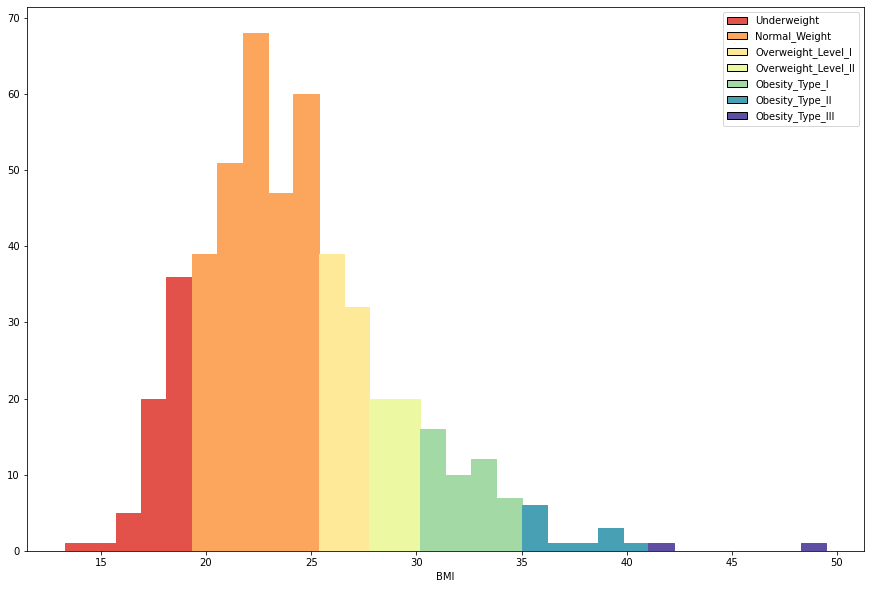

In [7]:
#calculate mass body index and graph
df['BMI']=np.round(df.Weight/(df.Height*df.Height), 3)

plt.figure(figsize=(15,10))
n, bins, patches=plt.hist(df.BMI,30)
bounds=[18.5,25.0,27.0,30.0,35.0,40.0]
cmap=plt.get_cmap('Spectral')

for bar in patches:
    x, y = bar.get_xy()
    w = bar.get_width()
    if x < bounds[0]:
        bar.set_color(cmap(1/7))
    elif x < bounds[1] and x >= bounds[0]:
        bar.set_color(cmap(2/7))
    elif x < bounds[2] and x >= bounds[1]:
        bar.set_color(cmap(3/7))
    elif x < bounds[3] and x >= bounds[2]:
        bar.set_color(cmap(4/7))
    elif x < bounds[4] and x >= bounds[3]:
        bar.set_color(cmap(5/7))
    elif x < bounds[5] and x >= bounds[4]:
        bar.set_color(cmap(6/7))
    elif x >= bounds[5]:
        bar.set_color(cmap(1.0))
        
handles=[matplotlib.patches.Rectangle((0,0),1,1,color=c,ec='k') for c in [cmap(i/7) for i in range(1,8)]]
labels=[lvl for lvl in df.obesity_lvl.unique()]
labels.pop(4)
labels.insert(0, 'Underweight')
df.obesity_lvl=df.obesity_lvl.replace('Insufficient_Weight', 'Underweight')
plt.legend(handles,labels)
plt.xlabel('BMI')

plt.show()

#we have an abundance of normal weight data

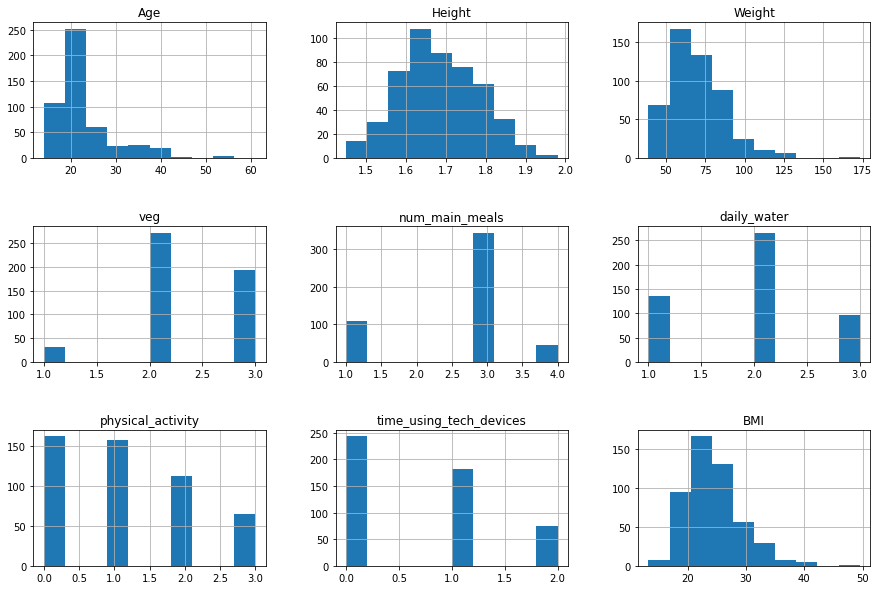

In [8]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

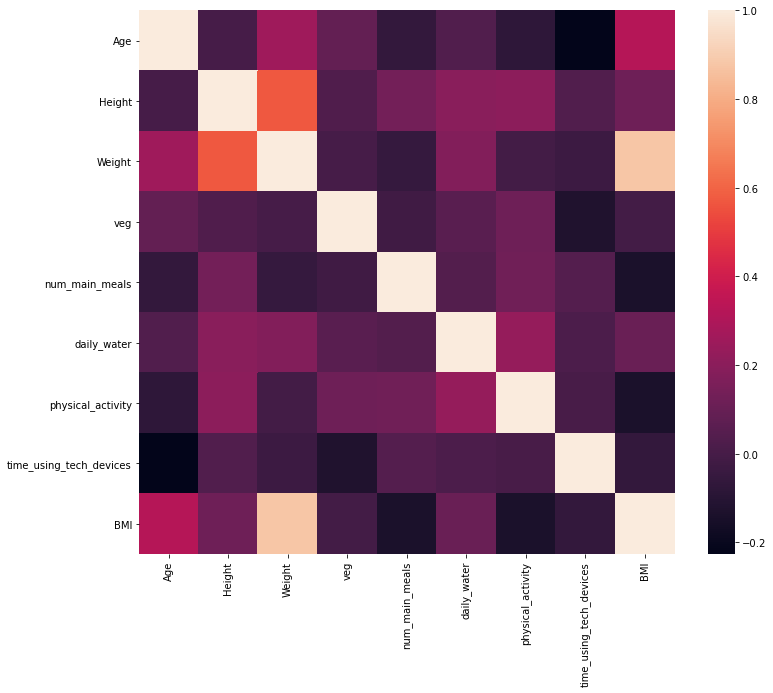

In [9]:
import seaborn as sns
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr());

Height and weight are of course positively correlated. BMI and weight are positively correlated as BMI is a function of weight. Age and BMI are slightly correlated, as well as physical activity and daily water intake. 
Time using tech devices and physical activity surprisingly is not correlated. There seems to be no other correlations that stand out, but we should also consider the categorical variables which are not shown in the heatmap. 

In [10]:
#print min, max, counts for obesity levels

ob1=df[df.obesity_lvl=='Overweight_Level_I']
ob2=df[df.obesity_lvl=='Overweight_Level_II']
print([[df[df.obesity_lvl==lvl].min().BMI, df[df.obesity_lvl==lvl].max().BMI, \
        df[df.obesity_lvl==lvl].BMI.count(), lvl] for lvl in labels])


[[13.292, 18.424, 34, 'Underweight'], [18.491, 24.913, 287, 'Normal_Weight'], [25.076, 26.892, 58, 'Overweight_Level_I'], [26.99, 29.938, 58, 'Overweight_Level_II'], [30.11, 34.894, 47, 'Obesity_Type_I'], [35.003, 39.258, 11, 'Obesity_Type_II'], [40.645, 49.472, 3, 'Obesity_Type_III']]


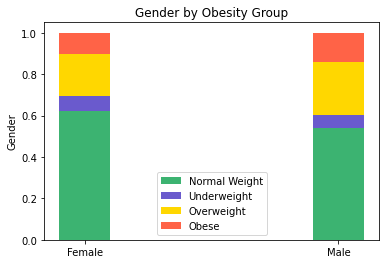

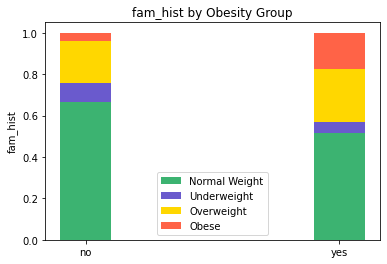

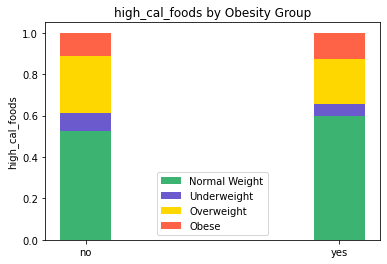

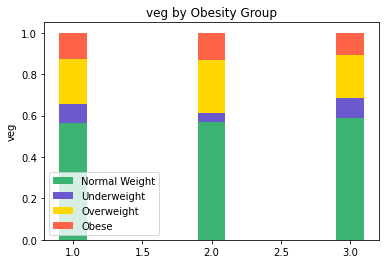

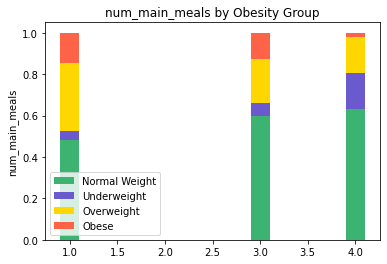

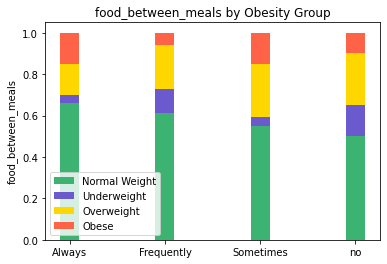

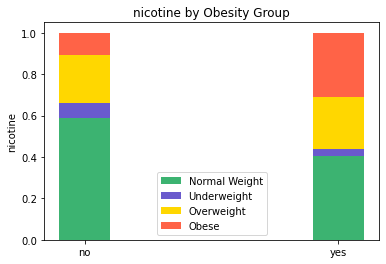

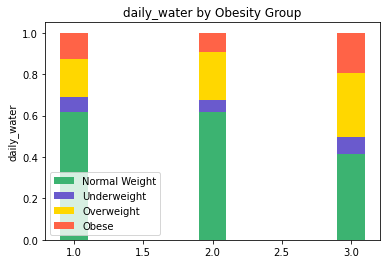

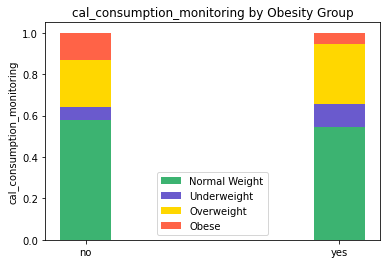

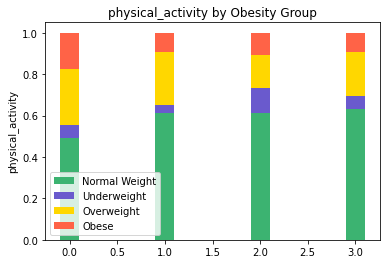

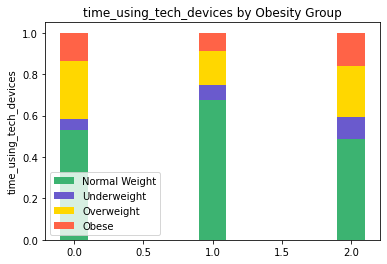

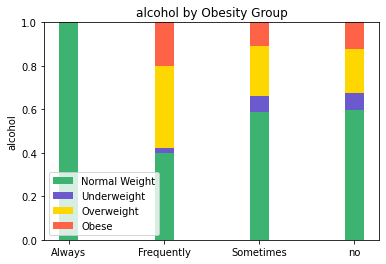

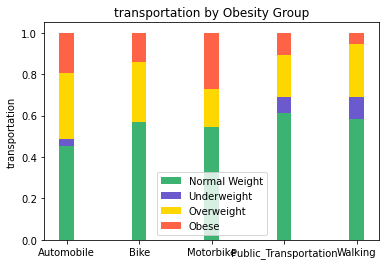

In [11]:
def categorize(column):
    underweight=[]
    normalweight=[]
    overweight=[]
    obese=[]
    for category in sorted(df[column].unique()):
        underweight.append(len(df[(df[column]==category) & (df.obesity_lvl=='Underweight')])/len(df[df[column]==category]))
        normalweight.append(len(df[(df[column]==category) & (df.obesity_lvl=='Normal_Weight')])/len(df[df[column]==category]))
        overweight.append(len(df[(df[column]==category) & ((df.obesity_lvl=='Overweight_Level_I') \
                            | (df.obesity_lvl=='Overweight_Level_II'))])/len(df[df[column]==category]))
        obese.append(len(df[(df[column]==category) & ((df.obesity_lvl=='Obesity_Type_I') \
                            | (df.obesity_lvl=='Obesity_Type_II') | (df.obesity_lvl=='Obesity_Type_III'))])\
                             /len(df[df[column]==category]))

    underweight=np.array(underweight)
    normalweight=np.array(normalweight)
    overweight=np.array(overweight)
    obese=np.array(obese)
    
    width=0.2
    fig, ax = plt.subplots()
    x_labels=['Underweight', 'Normal weight', 'Overweight']
    ax.bar(sorted(df[column].unique()), normalweight, label='Normal Weight', width=width, color='mediumseagreen')
    ax.bar(sorted(df[column].unique()), underweight, label='Underweight', bottom=normalweight, width=width, color='slateblue')
    ax.bar(sorted(df[column].unique()), overweight, label='Overweight', bottom=normalweight+underweight, width=width, color='gold')
    ax.bar(sorted(df[column].unique()), obese, label='Obese', bottom=overweight+normalweight+underweight, width=width, color='tomato')
    ax.set_ylabel(column)
    ax.set_title(column + ' by Obesity Group')
    ax.legend(fontsize=10)
    plt.show()

for col in df.columns:
    if col not in ('obesity_lvl', 'Height', 'Weight', 'Age', 'BMI'):
        categorize(col)



The percentage of people having a healthy weight is higher in females than males, but the underweight percentage is higher (genetic/sociocultural?).

Having overweight family members also seems to increase the chances of being overweight (can be genetic or from learned eating habits). 

A higher consumption of high caloric foods, vegetables, main meals, and food between meals is also surpringly correlated with a higher percentage of normal weight. 

The percentage of underweight people increases with the number of main meals - they may divide up their daily food consumption into smaller portions as they eat more frequently.

Inhibiting nicotine and alcohol intake seems to increase the percentage of normal weight but the data for alcohol should be reviewed further.

Obesity is higher in people who have more daily water intake. 

Transportation is a categorical variable that may be correlated with physical activity as transportation methods requiring less physical activity shows more obesity counts. (Obesity is lower in people who have more physical activity).

In [12]:
df.alcohol.value_counts()

Sometimes     273
no            179
Frequently     45
Always          1
Name: alcohol, dtype: int64

In [13]:
df[df['alcohol']=='Always']

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
26,Male,21.0,1.7,65.0,yes,yes,2.0,1.0,Frequently,no,2.0,no,1.0,2.0,Always,Walking,Normal_Weight,22.491


Only one person responded 'Always' to alcohol consumption. We should remove this data and others with value counts under 20 (public transportation = motorbike or bike).

In [14]:
for column in df.columns:
    if column not in ('obesity_lvl', 'Height', 'Weight', 'Age', 'BMI'):
        print(df[column].value_counts())

Male      271
Female    227
Name: Gender, dtype: int64
yes    300
no     198
Name: fam_hist, dtype: int64
yes    348
no     150
Name: high_cal_foods, dtype: int64
2.0    272
3.0    194
1.0     32
Name: veg, dtype: int64
3.0    344
1.0    108
4.0     46
Name: num_main_meals, dtype: int64
Sometimes     289
Frequently    136
Always         53
no             20
Name: food_between_meals, dtype: int64
no     466
yes     32
Name: nicotine, dtype: int64
2.0    266
1.0    135
3.0     97
Name: daily_water, dtype: int64
no     443
yes     55
Name: cal_consumption_monitoring, dtype: int64
0.0    162
1.0    158
2.0    113
3.0     65
Name: physical_activity, dtype: int64
0.0    243
1.0    181
2.0     74
Name: time_using_tech_devices, dtype: int64
Sometimes     273
no            179
Frequently     45
Always          1
Name: alcohol, dtype: int64
Public_Transportation    326
Automobile                99
Walking                   55
Motorbike                 11
Bike                       7
Name: transp

In [27]:
final_df=df.drop(df[df['alcohol']=='Always'].index)
final_df=df.drop(df[df['transportation']=='Motorbike'].index)
final_df=df.drop(df[df['transportation']=='Bike'].index)

In [30]:
final_df

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.387
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Male,25.0,1.66,68.0,no,yes,2.0,3.0,Sometimes,yes,1.0,no,1.0,1.0,Sometimes,Public_Transportation,Normal_Weight,24.677
492,Male,45.0,1.70,86.0,no,yes,3.0,3.0,Frequently,no,1.0,no,0.0,0.0,no,Automobile,Overweight_Level_II,29.758
494,Female,18.0,1.67,66.0,no,yes,3.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Normal_Weight,23.665
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation,Underweight,17.915


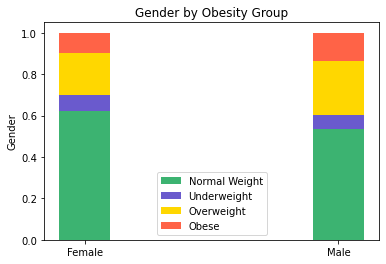

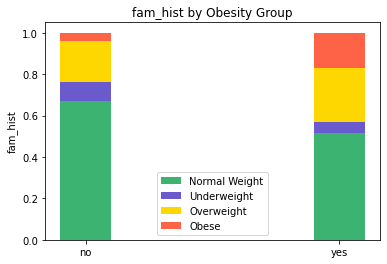

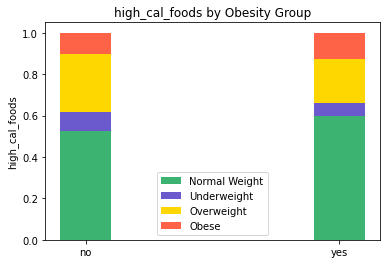

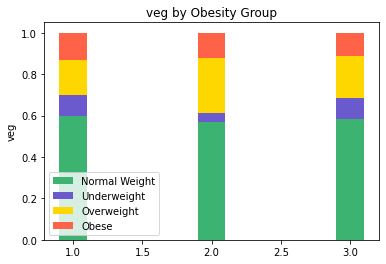

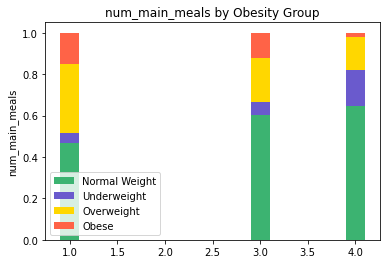

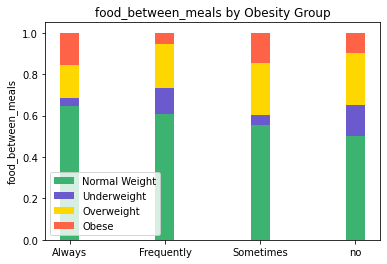

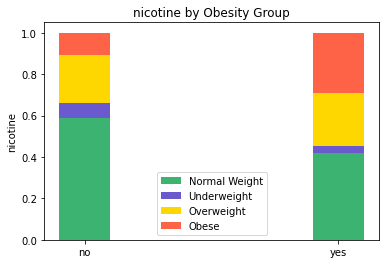

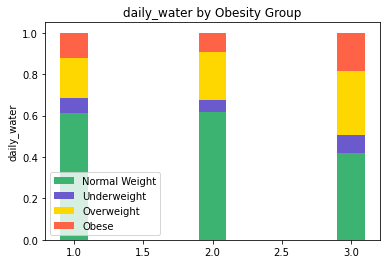

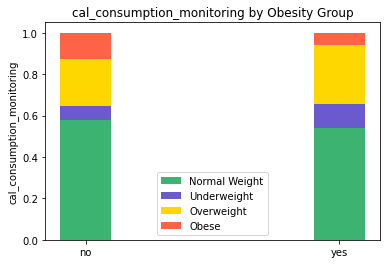

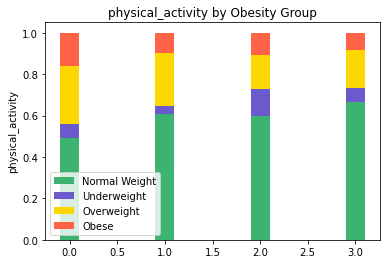

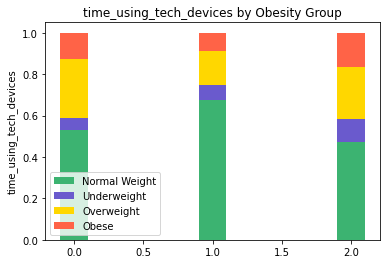

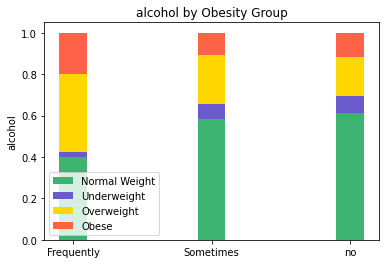

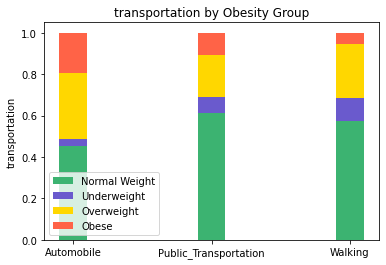